# Fake News Detection

### Steps to be followed
- 1. Importing Libraries and Datasets
- 2. Data Preprocessing
- 3. Preprocessing and analysis of News column
- 4. Converting text into vectors
- 5. Model training, evaluation and prediction 

## Importing Libraries and Datasets

###### Libraries used are:
* pandas: for importing the dataset
* seaborn/matplotlib: for data visualization

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

###### Importing the downloaded dataset

In [2]:
data = pd.read_csv('News.csv',index_col=0)

In [3]:
data.describe()

,class
count,44919.000000
mean,0.476792
std,0.499467
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Data Preprocessing

* The shape of the dataset 

In [5]:
data.shape

(44919, 5)

* As the title, subject and date columns will not be going to be healpful in identification of the news. So, we can drop these columns

In [6]:
data=data.drop(['title','subject','date'], axis=1)

* Checking if there are any null values (we will drop those rows)

In [7]:
data.isnull().sum()

text     0
class    0
dtype: int64

* so there is no null value

* Now we have to shuffle the dataset to prevent the model to get bias.
* After that we will reset the index and then drop it as it is not useful to us.

In [8]:
data=data.sample(frac=1)
data.reset_index(inplace=True)
data.drop(['index'],axis=1,inplace=True)

* Exploring the unique values in the each category 

<Axes: xlabel='class', ylabel='count'>

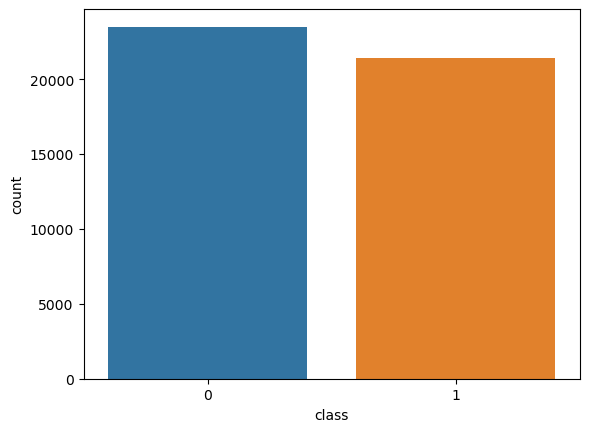

In [9]:
sns.countplot(data=data,x='class',order=data['class'].value_counts().index)

## Preprocessing and analysis of News column

* We have to remove all the stopwords, punctuation and any irrevalent spaces from the text.
* For this NLTK library is required.
* Some of its modules must be downloaded

In [10]:
from tqdm import tqdm
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

* All the required modules are imported.

* To preprocess the data let us define a function

In [11]:
def preprocess(data):
    preprocessed = []
    for sentence in tqdm(data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))
  
    return preprocessed

* Implementing the function to all the news in the text column
* This command will take some time as the dataset is very large

In [12]:
preprocessed = preprocess(data['text'].values)
data['text'] = preprocessed

100%|██████████████████████████████████████████████████████████████████████████| 44919/44919 [5:42:59<00:00,  2.18it/s]


* Word Cloud for real news

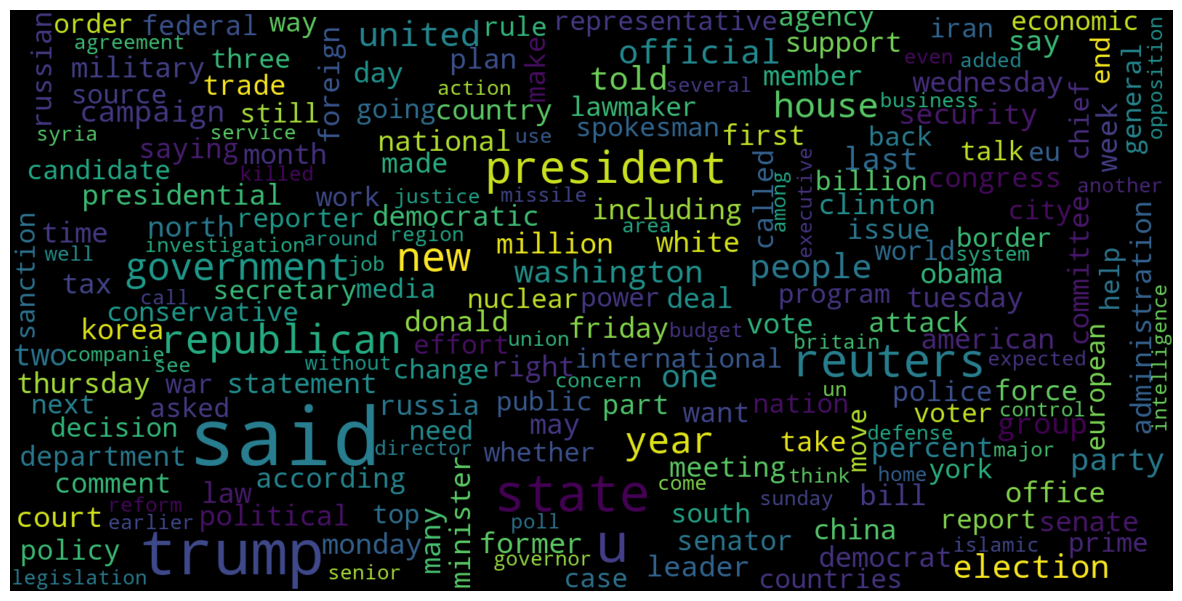

In [13]:
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

* Word Cloud for fake news

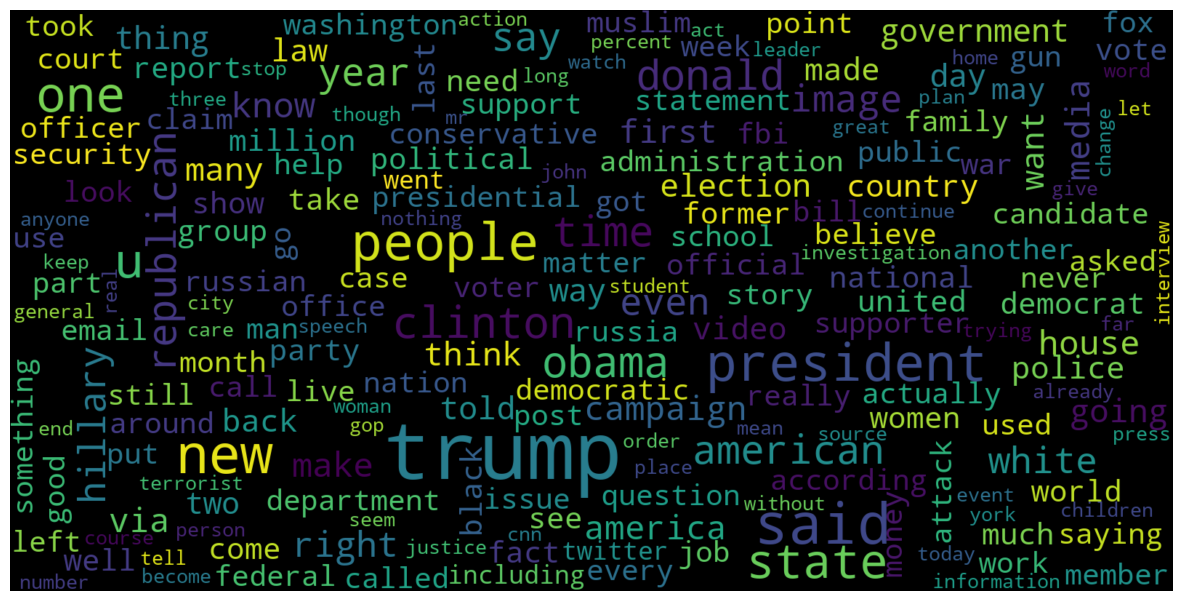

In [14]:
consolidated = ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

#### Plot the bargraph of the 20 most frequent words

<Axes: title={'center': 'Bar chart for top 20 words frequency'}, xlabel='Top words', ylabel='Count'>

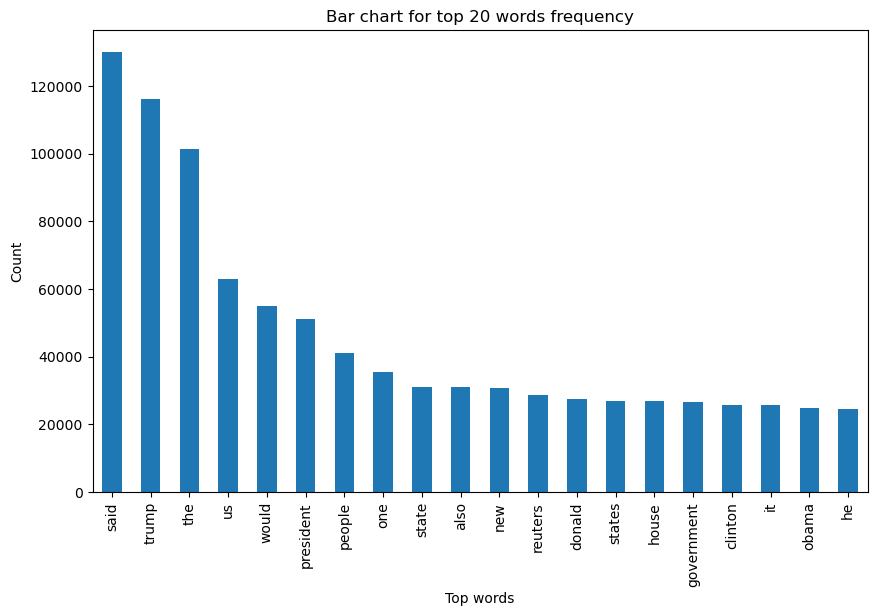

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(data,n=None):
    vec=CountVectorizer().fit(data)
    words=vec.transform(data)
    sum_words=words.sum(axis=0)
    words_freq=[(w,sum_words[0,idx])
               for w, idx in vec.vocabulary_.items()]
    words_freq=sorted(words_freq,key=lambda x:x[1],reverse=True)
    return words_freq[:n]
words_freq=get_top_n_words(data['text'],20)
df=pd.DataFrame(words_freq,columns=['Review','Count'])
df.groupby('Review').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10,6),
    xlabel='Top words',
    ylabel='Count',
    title='Bar chart for top 20 words frequency'
)

## Converting text into vectors

* Before converting the data into vectors, split it into train and test

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
x_train,x_test,y_train,y_test = train_test_split(data['text'],
                                                 data['class'],
                                                 test_size=0.25)

* Conveting the training data into vectors using TfidfVectorizer

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
x_train=vec.fit_transform(x_train)
x_test=vec.transform(x_test)

## Model training, Evaluation, and Prediction

#### Using Logistic Reggrssion

In [33]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)
train_score = accuracy_score(y_train,lr_model.predict(x_train))
test_score = accuracy_score(y_test,lr_model.predict(x_test))
print('Accuracy score of Trained data: ',train_score)
print('Accuracy score of Testing data: ',test_score)

Accuracy score of Trained data:  0.9940039775594408
Accuracy score of Testing data:  0.9881567230632236


#### Using Decision tree classifier

In [35]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier()
dtc_model.fit(x_train,y_train)
train_score = accuracy_score(y_train,dtc_model.predict(x_train))
test_score = accuracy_score(y_test,dtc_model.predict(x_test))
print('Accuracy score of Trained data: ',train_score)
print('Accuracy score of Testing data: ',test_score)

Accuracy score of Trained data:  0.9999703167205913
Accuracy score of Testing data:  0.9970614425645592


* Confusion Matrix for Decision Tree Classifier

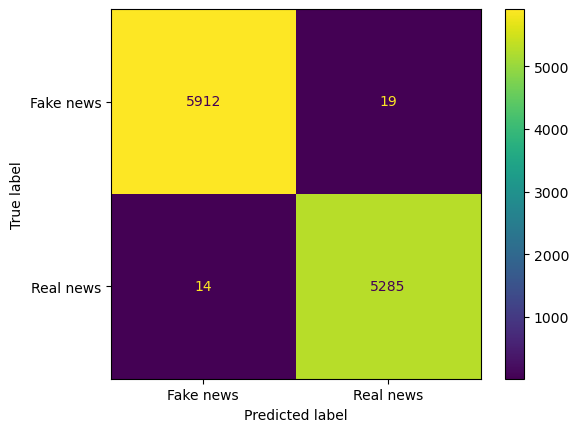

In [38]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, dtc_model.predict(x_test))
cmd = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=['Fake news','Real news'])
cmd.plot()
plt.show()

#### Decision Tree Classifier and Logistic Regression are performing well